In [2]:
import numpy as np
def Lorenz(xyz, s=10, r=28, b=2.667):
    x, y, z = xyz
    dx = s * (y - x)
    dy = x * (r - z) - y
    dz = x * y - b * z
    return np.array([dx, dy, dz])

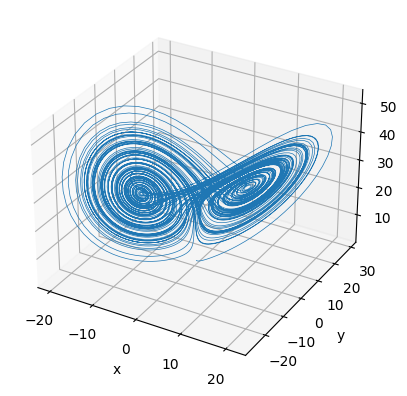

In [3]:
dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps+1, 3))
xyzs[0] = (0., 1., 1.05)

for i in range(num_steps):
    xyzs[i+1] = xyzs[i] + dt * Lorenz(xyzs[i])

import matplotlib.pyplot as plt
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

$$
\frac{1}{\gamma} \dot{\mathbf{r}}' = - \mathbf{r}' + \mathbf{g}( (A + BW) \mathbf{r}' + \mathbf{d})
$$

In [4]:
class ReservoirTanh:
    def __init__(self, A, B, C, rs, xs, cs, delT, gam):
        # Matrices
        self.A = A  # N x N matrix of internal reservoir connections
        self.B = B  # N x M matrix of s dynamical inputs to learn
        self.C = C  # N x K matrix of k exeternal inputs for control

        # States and fiexed points
        self.rs = rs
        self.xs = xs
        self.cs = cs
        # To ensure non-driven resorvoir begins with stable dynamics,
        # we initialize resovoir parameters by first selecting a distribution of
        # equlibrium points, and then selecting the bias term to achieve that
        # equilibrium point:
        # \dot{r} = 0 = -r + tanh(Ar + Bx + Cc + d)
        self.d = np.arctnah(rs) - np.dot(A, rs) - np.dot(B, xs) - np.dot(C, cs)

        # Time
        self.delT = delT
        self.gam = gam

        # Initialize reservoir
        self.r = np.zeros(A.shape[0])

    def train(self, x, c):
        nx = x.shape[1]
        D = np.zeros((self.A.shape[0], nx))
        D[:, 0] = self.r
        for i in range(1, nx):
            self.propagate(x[:, i-1, :], c[:, i-1, :])
            D[:, i] = self.r
        return D
    
    def propagate(self, x, c):
        # Runge-Kutta 4th order integration
        k1 = self.delT * self.del_r(self.r, x[:, 0, 0], c[:, 0, 0])
        k2 = self.delT * self.del_r(self.r + 0.5 * k1, x[:, 0, 1], c[:, 0, 1])
        k3 = self.delT * self.del_r(self.r + 0.5 * k2, x[:, 0, 2], c[:, 0, 2])
        k4 = self.delT * self.del_r(self.r + k3, x[:, 0, 3], c[:, 0, 3])
        self.r = self.r + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    def del_r(self, r, x, c):
        return self.gam * (-r + np.tanh(np.dot(self.A, r) + np.dot(self.B, x) + np.dot(self.C, c) + self.d))

    def predict_x(self, c, W):
        nc = c.shape[1]
        self.r = self.A + np.dot(self.B, W)
        D = np.zeros((self.r.shape[0], nc))
        D[:, 0] = self.r
        for i in range(1, nc):
            self.propagate_x(c[:, i-1, :])
            D[:, i] = self.r
        return D
    
    def propagate_x(self, c):
        # Runge-Kutta 4th order integration
        k1 = self.delT * self.del_r_x(self.r, c[:, 0, 0])
        k2 = self.delT * self.del_r_x(self.r + 0.5 * k1, c[:, 0, 1])
        k3 = self.delT * self.del_r_x(self.r + 0.5 * k2, c[:, 0, 2])
        k4 = self.delT * self.del_r_x(self.r + k3, c[:, 0, 3])
        self.r = self.r + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    
    def del_r_x(self, r, c):
        return self.gam * (-r + np.tanh(np.dot(self.r, r) + np.dot(self.C, c) + self.d))